In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.model_selection import train_test_split  , StratifiedKFold ,KFold
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score , classification_report , roc_curve, auc
from keras import callbacks

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[]


# LOADING DATA

In [3]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# Data Cleaning

convert Date column to date type

In [5]:
df['Date']= pd.to_datetime(df["Date"])
#Creating a collumn of year
df['year'] = df.Date.dt.year

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

df['month'] = df.Date.dt.month
data = encode(df, 'month', 12)

df['day'] = df.Date.dt.day
df = encode(data, 'day', 31)

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


In [6]:
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
year                 0
month                0
month_sin            0
month_cos            0
day                  0
day_sin              0
day_cos              0
dtype: int64

In [7]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df_categorical = df[categorical_cols]
df_categorical.head()

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,Albury,W,W,WNW,No,No
1,Albury,WNW,NNW,WSW,No,No
2,Albury,WSW,W,WSW,No,No
3,Albury,NE,SE,E,No,No
4,Albury,W,ENE,NW,No,No


In [8]:
df_categorical.isnull().sum()

Location            0
WindGustDir     10326
WindDir9am      10566
WindDir3pm       4228
RainToday        3261
RainTomorrow     3267
dtype: int64

In [9]:
#filling missing values using mod
# Calculate the mode for each categorical column
mode_values = df_categorical.mode().iloc[0]

# Fill missing values in categorical columns using the mode values
df_categorical.fillna(mode_values, inplace=True)



C:\Users\pc\AppData\Local\Temp\ipykernel_10348\1513303634.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical.fillna(mode_values, inplace=True)


In [10]:
df_categorical.isnull().sum()

Location        0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

In [11]:
numerical_cols = df.select_dtypes(include=['float64']).columns
df_numerical = df[numerical_cols]
df_numerical.sample(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,month_sin,month_cos,day_sin,day_cos
33183,7.8,14.3,0.0,4.0,5.4,46.0,22.0,15.0,50.0,39.0,1015.8,1012.1,7.0,2.0,8.7,13.6,-0.500000,-8.660254e-01,-0.988468,0.151428
93801,17.9,31.8,0.0,5.4,10.6,44.0,4.0,24.0,63.0,49.0,1015.8,1012.8,1.0,2.0,26.1,29.1,0.500000,-8.660254e-01,0.937752,0.347305
84072,15.6,19.7,6.0,7.8,0.0,43.0,11.0,13.0,90.0,92.0,1024.1,1020.1,8.0,8.0,16.0,15.9,-1.000000,-1.836970e-16,0.724793,0.688967
27200,20.5,34.0,0.0,8.0,NaN,46.0,6.0,28.0,69.0,37.0,1010.8,1008.7,NaN,NaN,24.0,31.9,0.866025,5.000000e-01,0.571268,0.820763
11637,16.2,25.5,0.0,NaN,NaN,33.0,2.0,13.0,69.0,74.0,1019.6,1016.7,NaN,NaN,24.1,24.6,0.866025,-5.000000e-01,-0.968077,-0.250653


In [12]:
df_numerical.isnull().sum()

MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
month_sin            0
month_cos            0
day_sin              0
day_cos              0
dtype: int64

In [13]:
df.sample()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
142673,2014-03-05,Katherine,24.6,34.6,0.0,8.0,NaN,SE,43.0,E,...,34.2,No,No,2014,3,1.0,6.123234e-17,5,0.848644,0.528964


In [14]:
df = df[['Date' , 'year' , 'month' , 'day']]
df.sample()

,Date,year,month,day
1632,2013-08-18,2013,8,18


In [15]:
df_numerical.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos'],
      dtype='object')

In [16]:
#fill null values
median_values = df_numerical.mean().iloc[0]

# Fill missing values in categorical columns using the mode values
df_numerical.fillna(median_values, inplace=True)

C:\Users\pc\AppData\Local\Temp\ipykernel_10348\2303584526.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical.fillna(median_values, inplace=True)


In [17]:
df_numerical.isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
month_sin        0
month_cos        0
day_sin          0
day_cos          0
dtype: int64

concatonate two dataframes in the original dataframe

In [18]:
# Convert DataFrame column names to lowercase
df_categorical.columns = df_categorical.columns.str.lower()
df_numerical.columns = df_numerical.columns.str.lower()

# Concatenate df_categorical and df_numerical column-wise
df1 = pd.concat([ df,df_categorical, df_numerical], axis=1)

In [19]:
df1.drop_duplicates(inplace=True)


c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

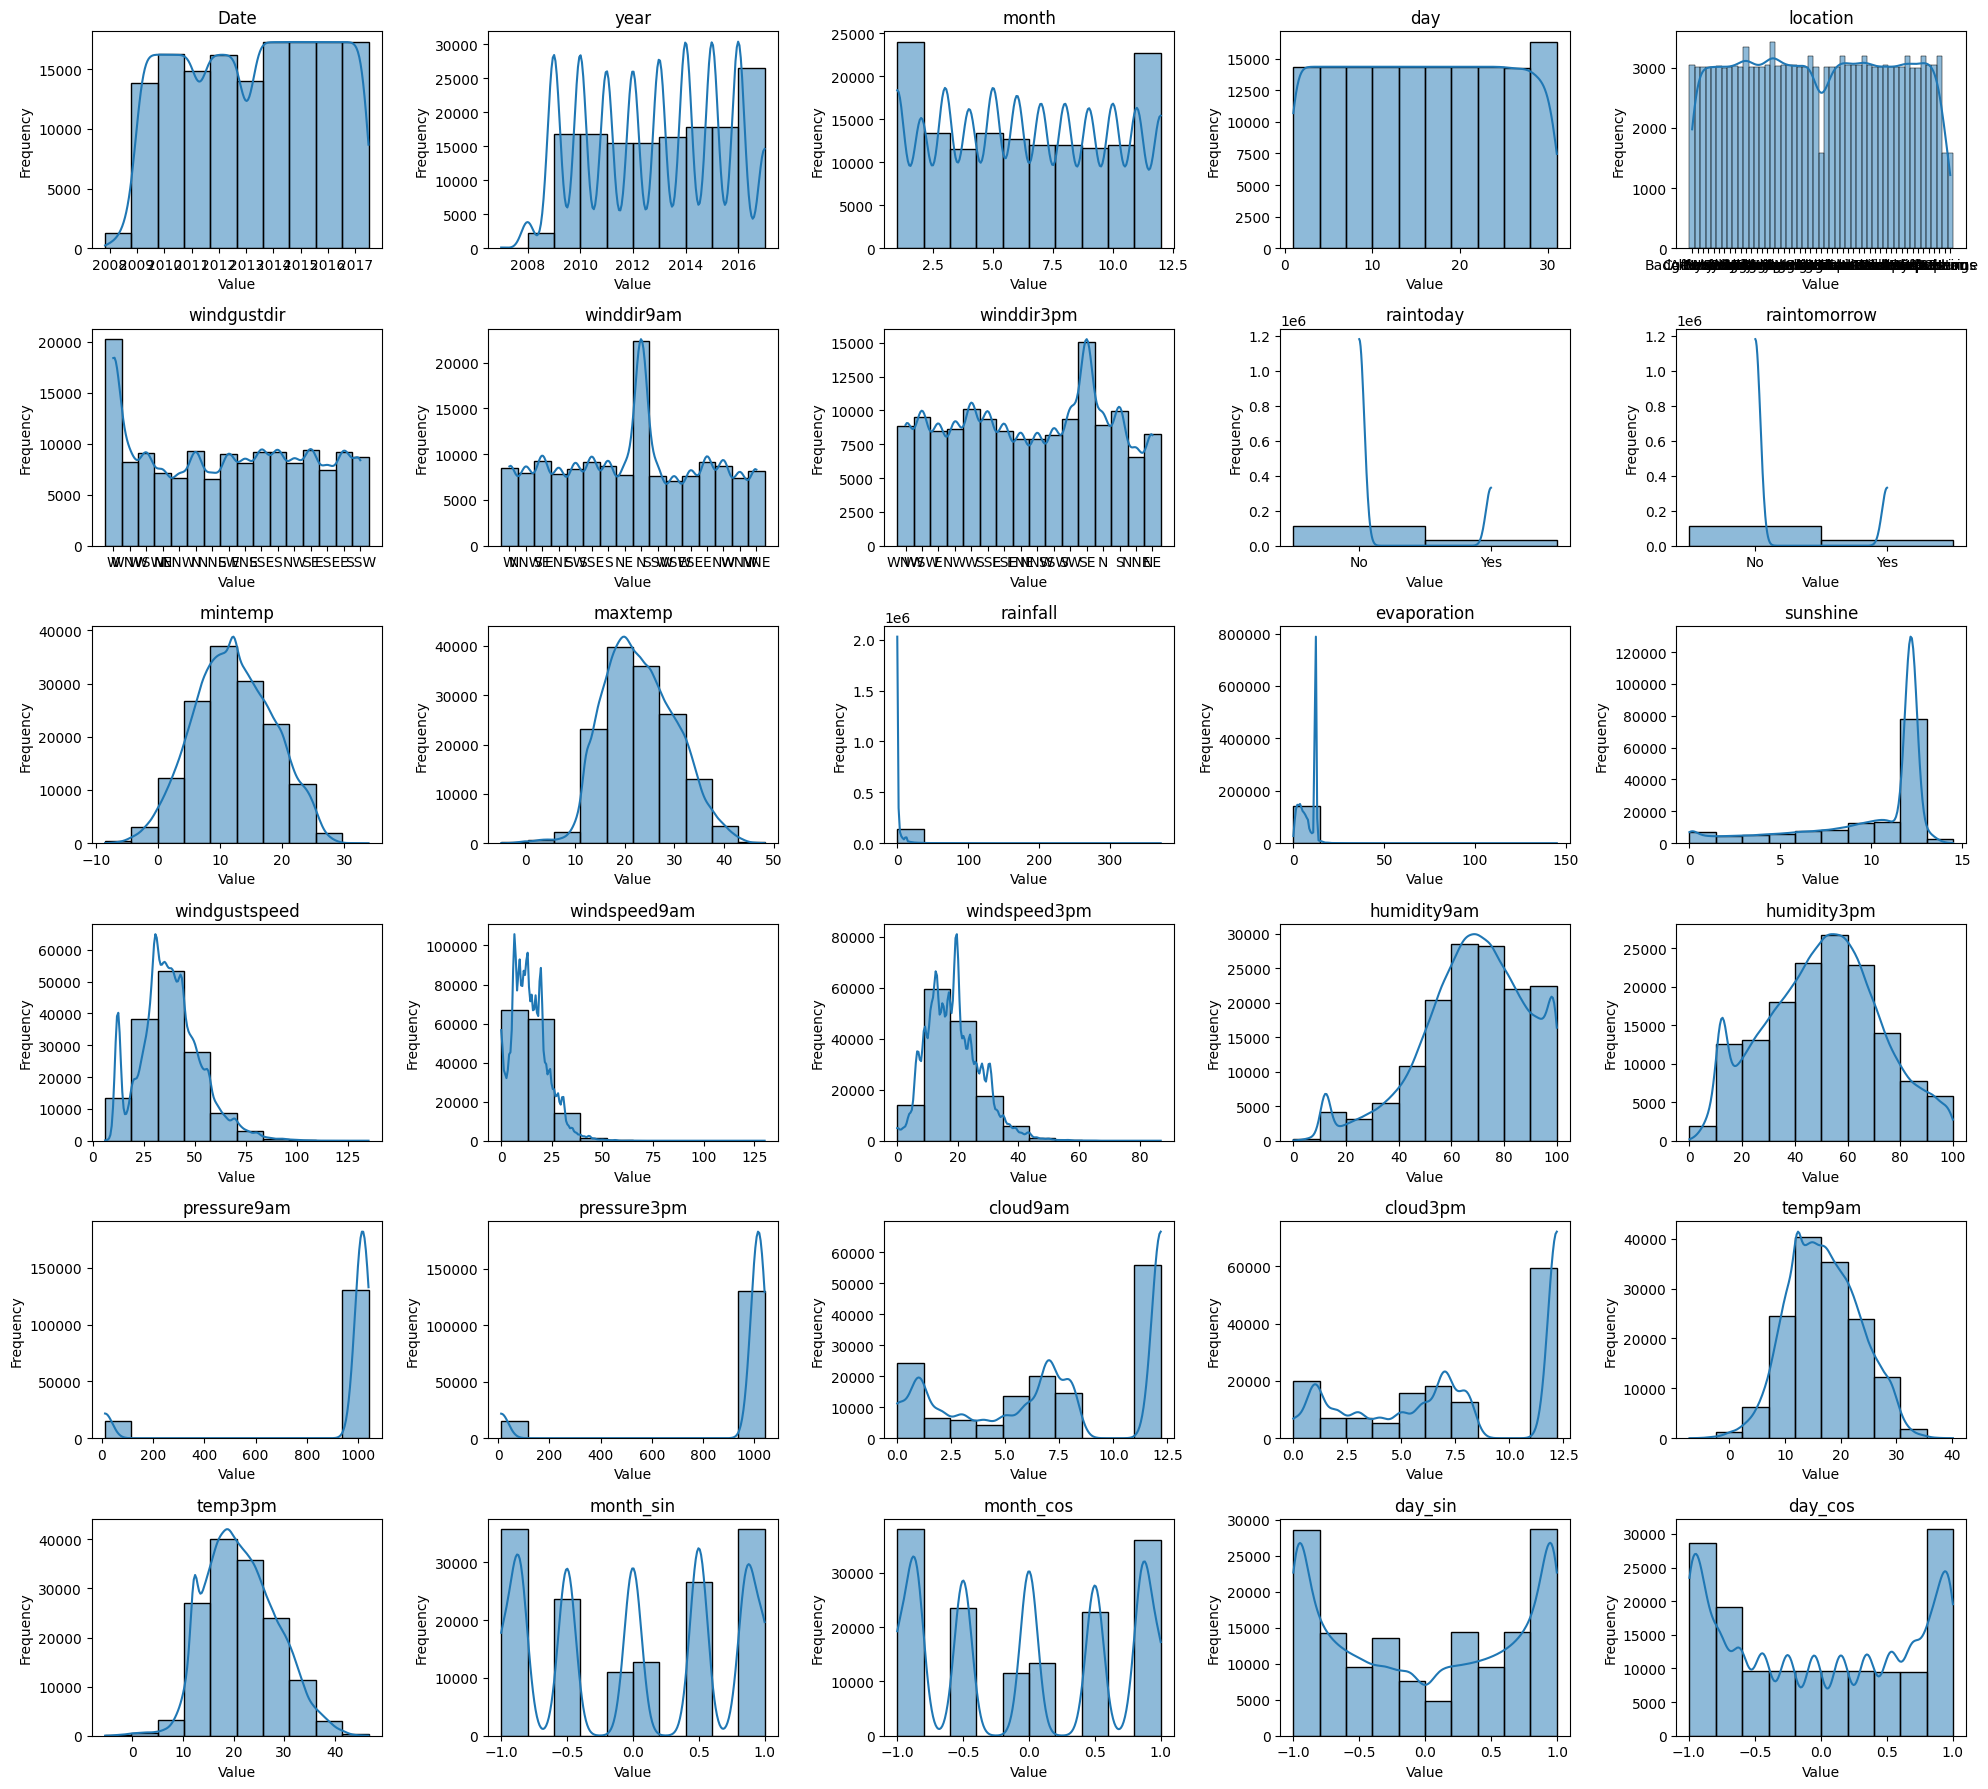

In [20]:
# Calculate the number of rows and columns for the subplots grid
num_columns = len(df1.columns)
nrows = num_columns // 5 + (1 if num_columns % 5 != 0 else 0)
ncols = 5

# Create a figure with the calculated rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 3))

# Flatten the array of axes for easier indexing
axes = axes.flatten()

# Iterate over each column and plot a histogram using Seaborn
for i, col in enumerate(df1.columns):
    sns.histplot(data=df1, x=col, ax=axes[i], bins=10, kde=True)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Remove any unused axes (in case there are more subplots than columns)
for j in range(num_columns, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

In [21]:
df1.sample(5)

,Date,year,month,day,location,windgustdir,winddir9am,winddir3pm,raintoday,raintomorrow,...,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,month_sin,month_cos,day_sin,day_cos
20604,2016-01-28,2016,1,28,NorahHead,NE,NNW,NE,Yes,Yes,...,1009.000000,1004.700000,12.194034,12.194034,20.9,26.4,5.000000e-01,0.866025,-0.571268,0.820763
15749,2010-10-05,2010,10,5,Newcastle,W,N,SE,Yes,Yes,...,12.194034,12.194034,7.000000,4.000000,19.4,22.0,-8.660254e-01,0.500000,0.848644,0.528964
90501,2009-08-19,2009,8,19,GoldCoast,S,SSE,SE,No,No,...,1027.200000,1023.300000,12.194034,12.194034,19.7,20.7,-8.660254e-01,-0.500000,-0.651372,-0.758758
128336,2013-05-16,2013,5,16,Walpole,W,N,SE,No,Yes,...,1013.000000,1009.500000,12.194034,12.194034,14.5,19.4,5.000000e-01,-0.866025,-0.101168,-0.994869
20025,2014-06-28,2014,6,28,NorahHead,NNW,N,N,No,No,...,1008.500000,1000.800000,12.194034,12.194034,14.8,17.9,1.224647e-16,-1.000000,-0.571268,0.820763


# some of Data Analysis & Visualisations

whats is amout of rainfall during year

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

Text(0.5, 1.0, 'Rainfall per year')

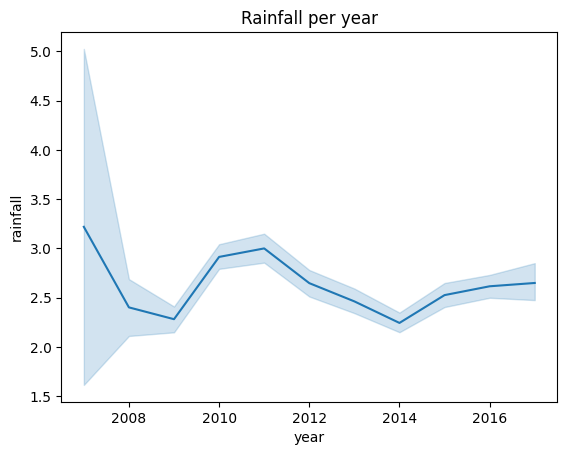

In [22]:
series = sns.lineplot(data=df1 , x='year', y='rainfall')
series.set_title('Rainfall per year')

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

Text(0.5, 1.0, 'Wind Speed average per year')

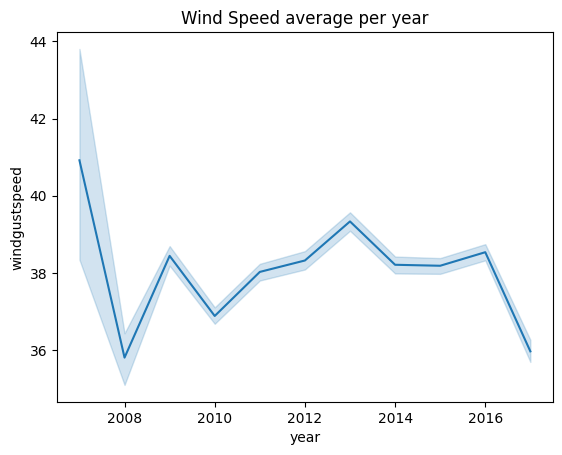

In [23]:
series = sns.lineplot(data=df1 , x='year', y='windgustspeed')
series.set_title('Wind Speed average per year')

In [24]:
# take the avg of humidity in different times
humidity_location = df1.groupby('location')[['humidity9am' , 'humidity3pm']].mean()
humidity_location = humidity_location.sort_values(by='humidity9am' , ascending=False)
humidity_location = humidity_location.reset_index()
humidity_location.head()

,location,humidity9am,humidity3pm
0,Ballarat,81.336867,58.923144
1,Dartmoor,79.684693,58.698125
2,Launceston,79.367159,57.173994
3,Sale,78.497403,56.133569
4,Watsonia,78.076011,54.708873


In [25]:
px.bar(data_frame=humidity_location,
        x='location',
        y='humidity9am',
        color='humidity9am')

In [26]:
px.bar(data_frame=humidity_location,
        x='location',
        y='humidity3pm',
        color='humidity3pm')

In [27]:
rainfall_location = df1.groupby('location' , as_index=False)['rainfall'].mean()
rainfall_location_sorted = rainfall_location.sort_values(by='rainfall', ascending=False)

# Select the top 10 locations
top_10_rainfall = rainfall_location_sorted.head(10)

# Create a pie chart with the top 10 locations
fig = px.pie(data_frame=top_10_rainfall,
            names='location',
            values='rainfall',
            title='Top 10 Locations by Rainfall')

# Show the pie chart
fig.show()

In [28]:
max_temp = df1.groupby('location' , as_index=False)['maxtemp'].mean()
max_temp=max_temp.sort_values(by='maxtemp',ascending=False)
px.bar(data_frame=max_temp,
        x='location',
        y='maxtemp',
        color='maxtemp')

In [29]:
raintom = df1.groupby('raintomorrow').size().reset_index(name='count')

px.bar(data_frame=raintom , x='raintomorrow' , y='count' , color='raintomorrow')

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



<Axes: xlabel='raintoday', ylabel='count'>

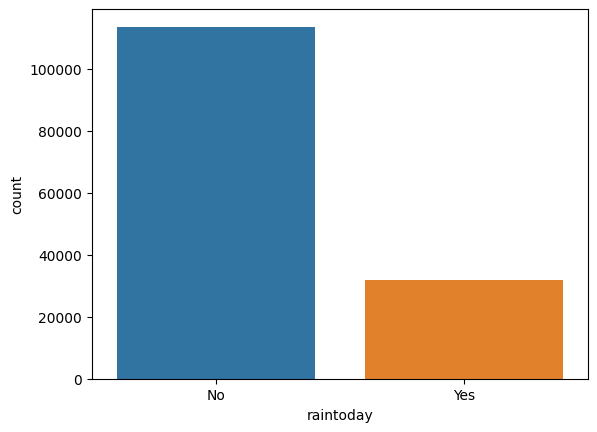

In [30]:
sns.countplot(data=df1 , 
            x='raintoday')

# Data Preprocessing

encoding the data using label encoder

In [31]:
cat_cols = df1.select_dtypes(include=['object', 'category']).columns
encoder = LabelEncoder()
for i in cat_cols:
    df1[i] = encoder.fit_transform(df1[i])


In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   year           145460 non-null  int32         
 2   month          145460 non-null  int32         
 3   day            145460 non-null  int32         
 4   location       145460 non-null  int32         
 5   windgustdir    145460 non-null  int32         
 6   winddir9am     145460 non-null  int32         
 7   winddir3pm     145460 non-null  int32         
 8   raintoday      145460 non-null  int32         
 9   raintomorrow   145460 non-null  int32         
 10  mintemp        145460 non-null  float64       
 11  maxtemp        145460 non-null  float64       
 12  rainfall       145460 non-null  float64       
 13  evaporation    145460 non-null  float64       
 14  sunshine       145460 non-null  float64       
 15  

In [33]:
df1.head()

,Date,year,month,day,location,windgustdir,winddir9am,winddir3pm,raintoday,raintomorrow,...,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,month_sin,month_cos,day_sin,day_cos
0,2008-12-01,2008,12,1,2,13,13,14,0,0,...,1007.7,1007.1,8.000000,12.194034,16.9,21.8,-2.449294e-16,1.0,0.201299,0.979530
1,2008-12-02,2008,12,2,2,14,6,15,0,0,...,1010.6,1007.8,12.194034,12.194034,17.2,24.3,-2.449294e-16,1.0,0.394356,0.918958
2,2008-12-03,2008,12,3,2,15,13,15,0,0,...,1007.6,1008.7,12.194034,2.000000,21.0,23.2,-2.449294e-16,1.0,0.571268,0.820763
3,2008-12-04,2008,12,4,2,4,9,0,0,0,...,1017.6,1012.8,12.194034,12.194034,18.1,26.5,-2.449294e-16,1.0,0.724793,0.688967
4,2008-12-05,2008,12,5,2,13,1,7,0,0,...,1010.8,1006.0,7.000000,8.000000,17.8,29.7,-2.449294e-16,1.0,0.848644,0.528964


In [34]:
df1.sample(3)

,Date,year,month,day,location,windgustdir,winddir9am,winddir3pm,raintoday,raintomorrow,...,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,month_sin,month_cos,day_sin,day_cos
24892,2011-01-05,2011,1,5,30,13,5,9,0,0,...,12.194034,12.194034,12.194034,12.194034,19.7,12.194034,0.5,8.660254e-01,0.848644,0.528964
105345,2016-11-21,2016,11,21,28,14,3,15,0,0,...,1006.900000,1008.000000,4.000000,12.194034,31.7,27.900000,-0.5,8.660254e-01,-0.897805,-0.440394
131835,2014-03-18,2014,3,18,15,14,6,7,0,0,...,1012.800000,1009.600000,12.194034,12.194034,12.8,21.600000,1.0,6.123234e-17,-0.485302,-0.874347


In [35]:
#scaling data using standard scaler
scaled_df = df1.drop(['Date','day', 'month'], axis=1)
col_names = list(scaled_df.columns)
s_scaler = StandardScaler()
scaled_df = s_scaler.fit_transform(scaled_df)
#target = s_scaler.fit_transform(target)
scaled_df = pd.DataFrame(scaled_df, columns=col_names)
scaled_df['raintomorrow'] = scaled_df['raintomorrow'].apply(lambda x: 0 if abs(x + 0.529764) < 1e-6 else 1 if abs(x - 1.887635) < 1e-6 else x)


c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\pc\AppData\Local\Programs\Python\Py

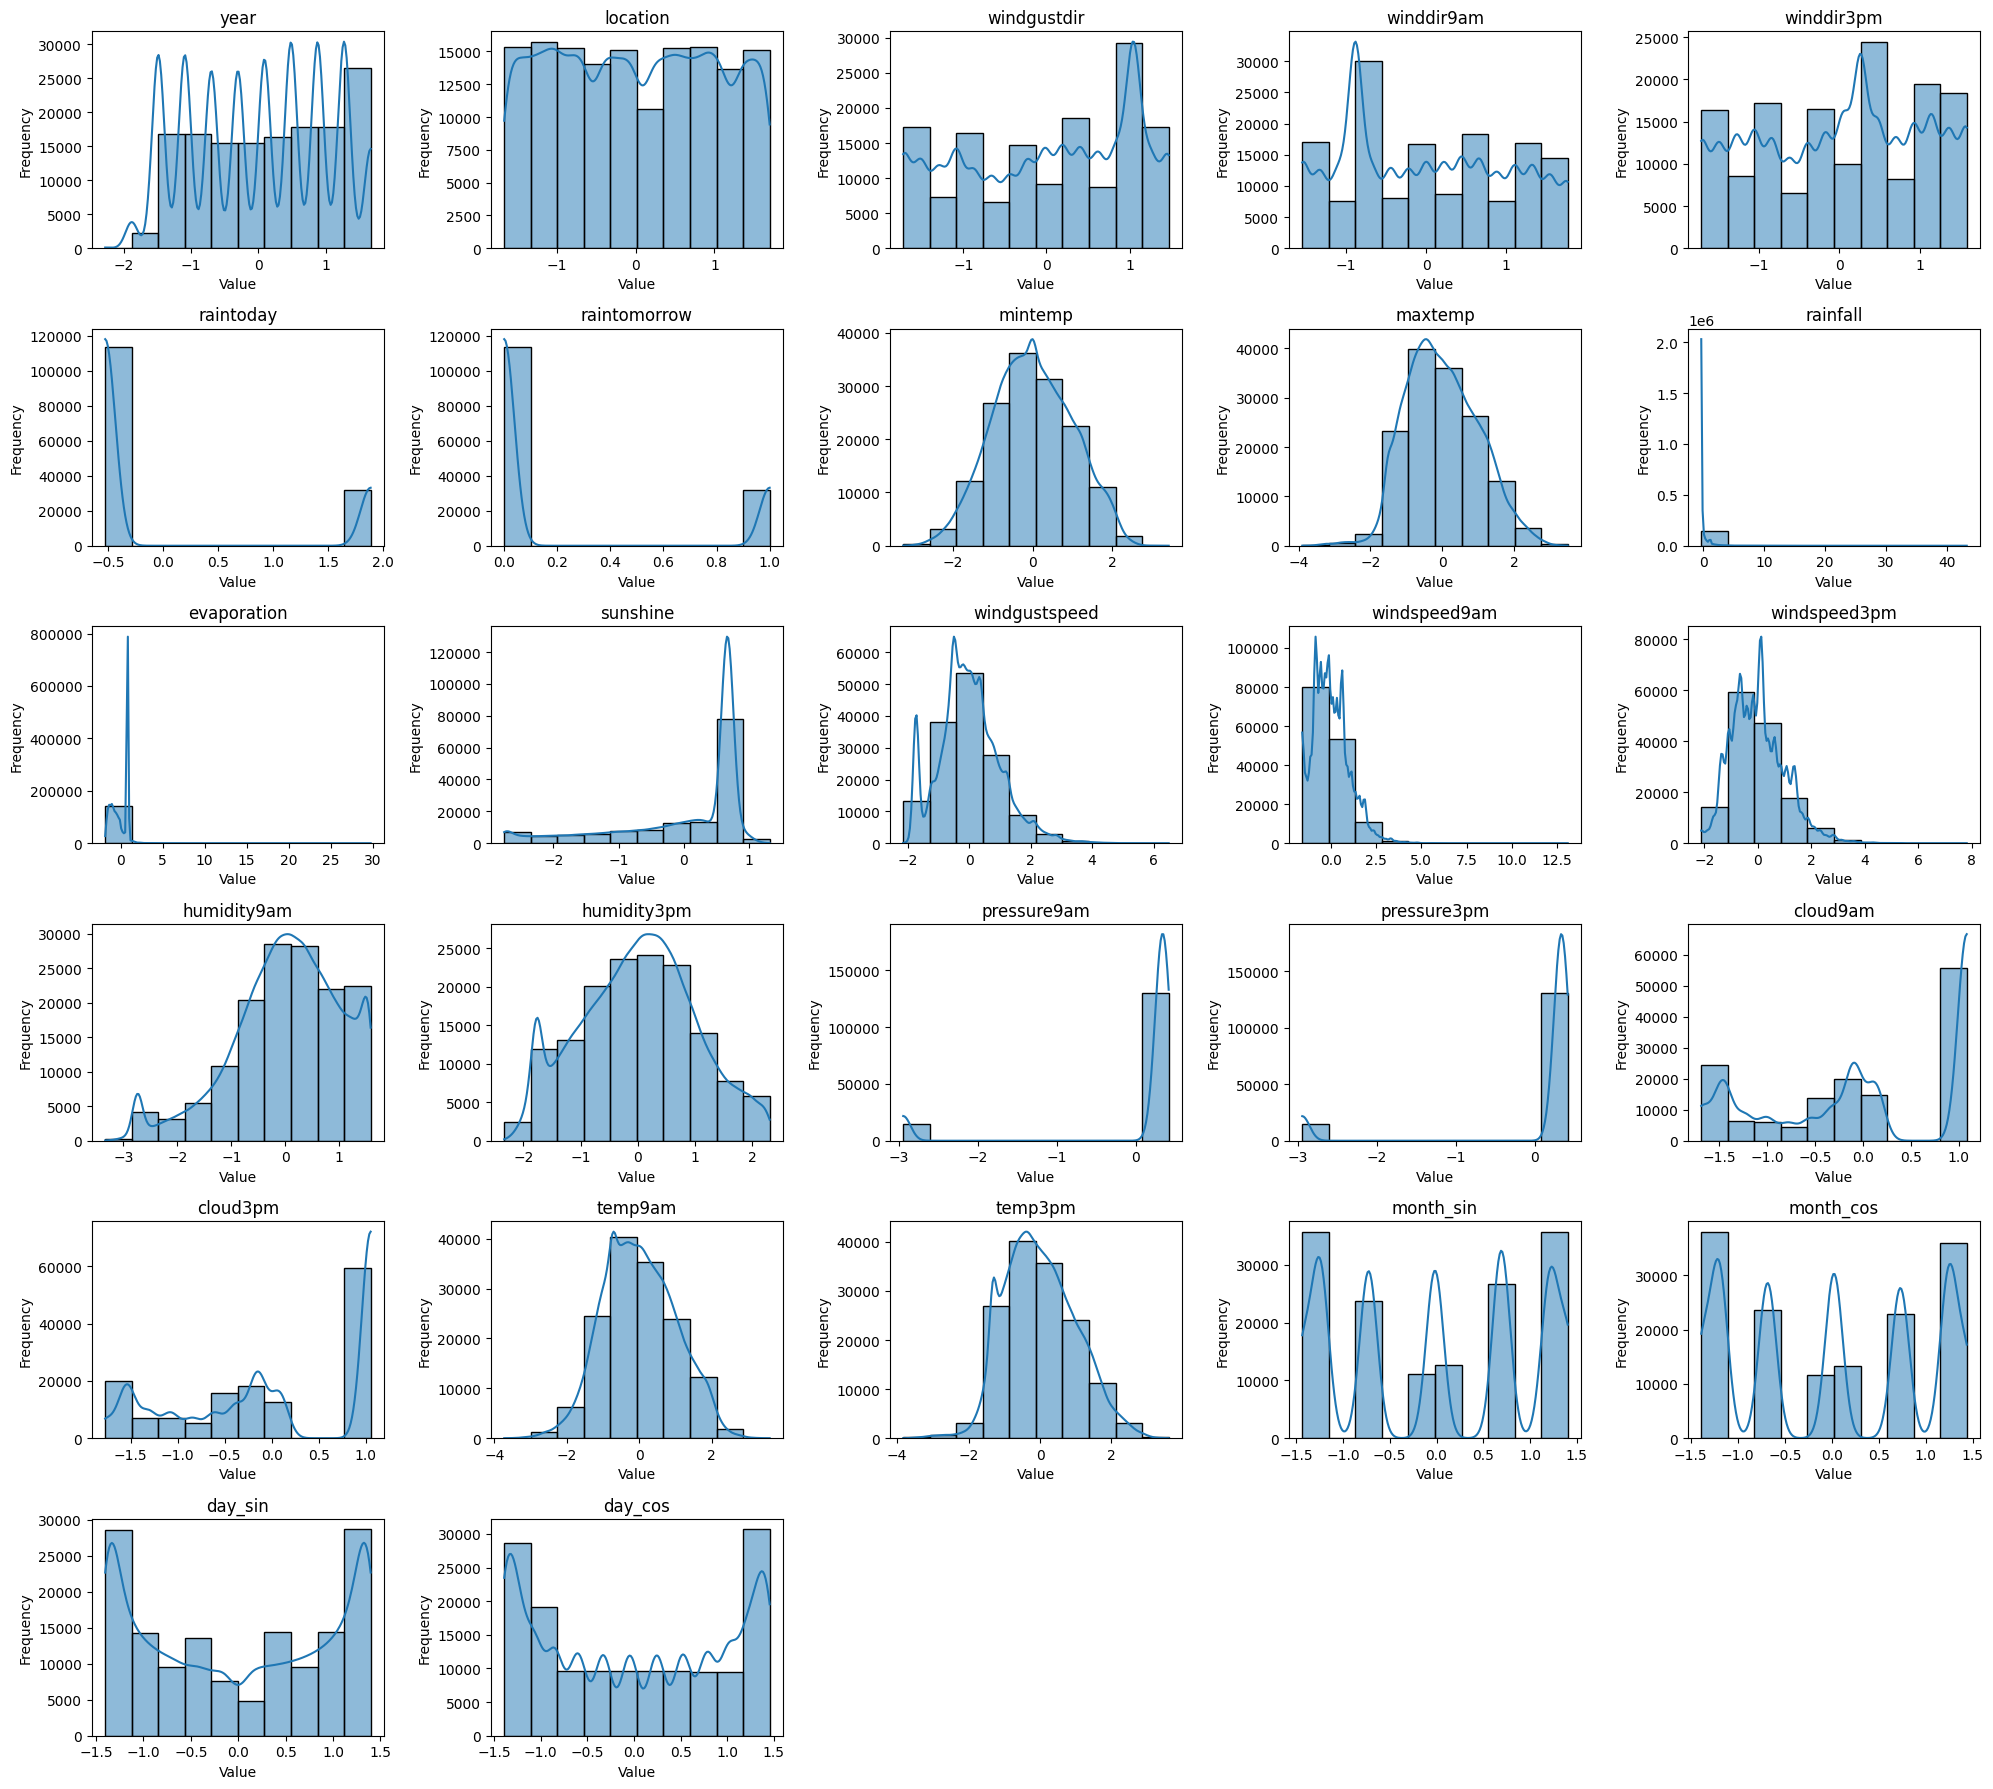

In [36]:
# Calculate the number of rows and columns for the subplots grid
num_columns = len(scaled_df.columns)
nrows = num_columns // 5 + (1 if num_columns % 5 != 0 else 0)
ncols = 5

# Create a figure with the calculated rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 3))

# Flatten the array of axes for easier indexing
axes = axes.flatten()

# Iterate over each column and plot a histogram using Seaborn
for i, col in enumerate(scaled_df.columns):
    sns.histplot(data=scaled_df, x=col, ax=axes[i], bins=10, kde=True)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Remove any unused axes (in case there are more subplots than columns)
for j in range(num_columns, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

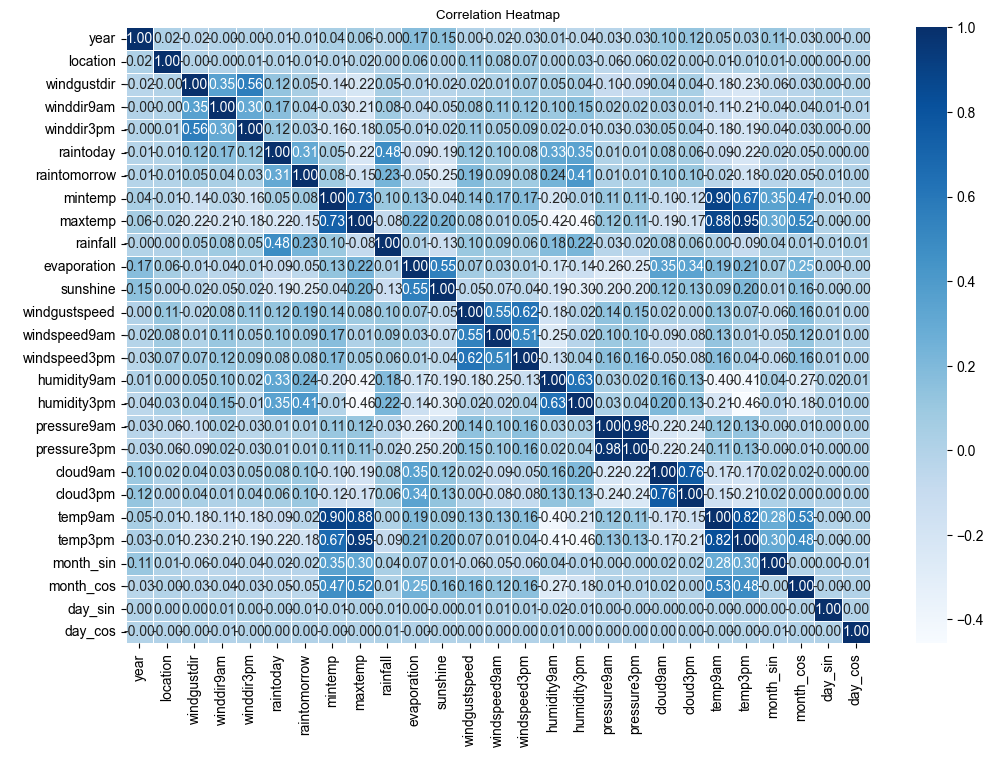

In [37]:
corr = scaled_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
sns.set(font_scale=0.8)
plt.title("Correlation Heatmap")
plt.show()

In [38]:
#drop highly correlated columns
#scaled_df = scaled_df.drop(['temp3pm' , 'temp9am' , 'cloud9am' , 'cloud3pm'] , axis=1)

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\

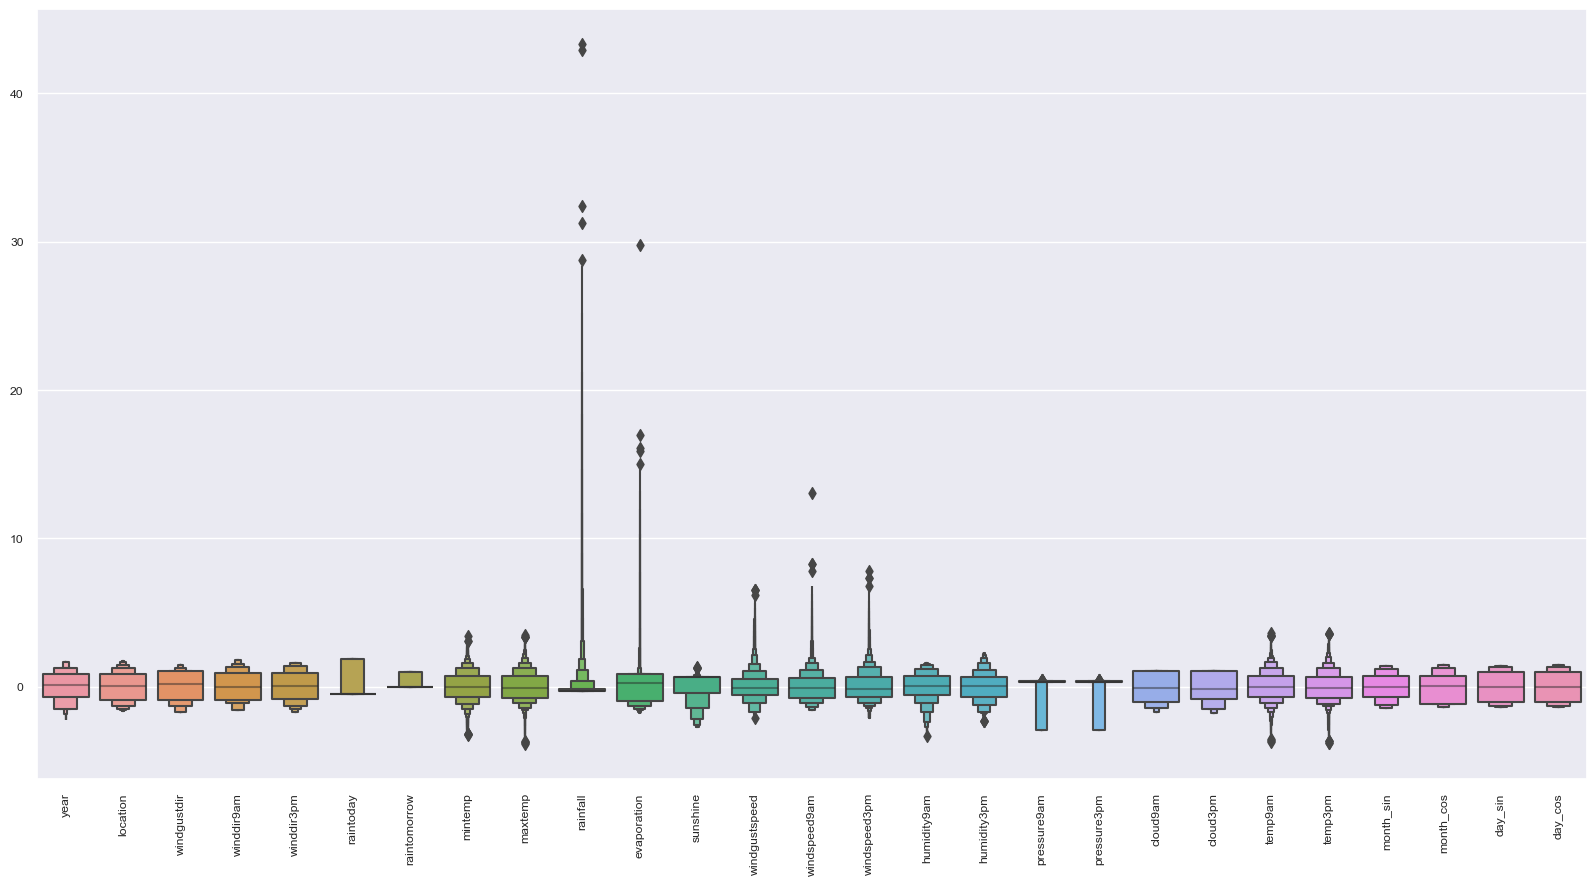

In [40]:
#detecting outliers
plt.figure(figsize=(20,10))
sns.boxenplot(data = scaled_df)
plt.xticks(rotation=90)
plt.show()

In [41]:
from scipy import stats
def remove_outliers_zscore(dataframe, threshold=3):
    # Calculate the Z-score for each column
    z_scores = stats.zscore(dataframe)
    
    # Filter the DataFrame based on the Z-score threshold
    filtered_dataframe = dataframe[(z_scores < threshold).all(axis=1)]
    
    return filtered_dataframe

# Define a function to remove outliers using IQR
def remove_outliers_iqr(dataframe, lower_multiplier=1.5, upper_multiplier=1.5):
    for column in dataframe.columns:
        # Calculate the first quartile (Q1) and third quartile (Q3) for the current column
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        
        # Calculate the interquartile range (IQR)
        IQR = Q3 - Q1
        
        # Calculate the lower and upper bounds using the specified multipliers
        lower_bound = Q1 - lower_multiplier * IQR
        upper_bound = Q3 + upper_multiplier * IQR
        
        # Filter the DataFrame based on the calculated bounds
        dataframe = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]
    
    return dataframe

# First, remove outliers using Z-score with a threshold of 2
scaled_df = remove_outliers_zscore(scaled_df, threshold=2)

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\

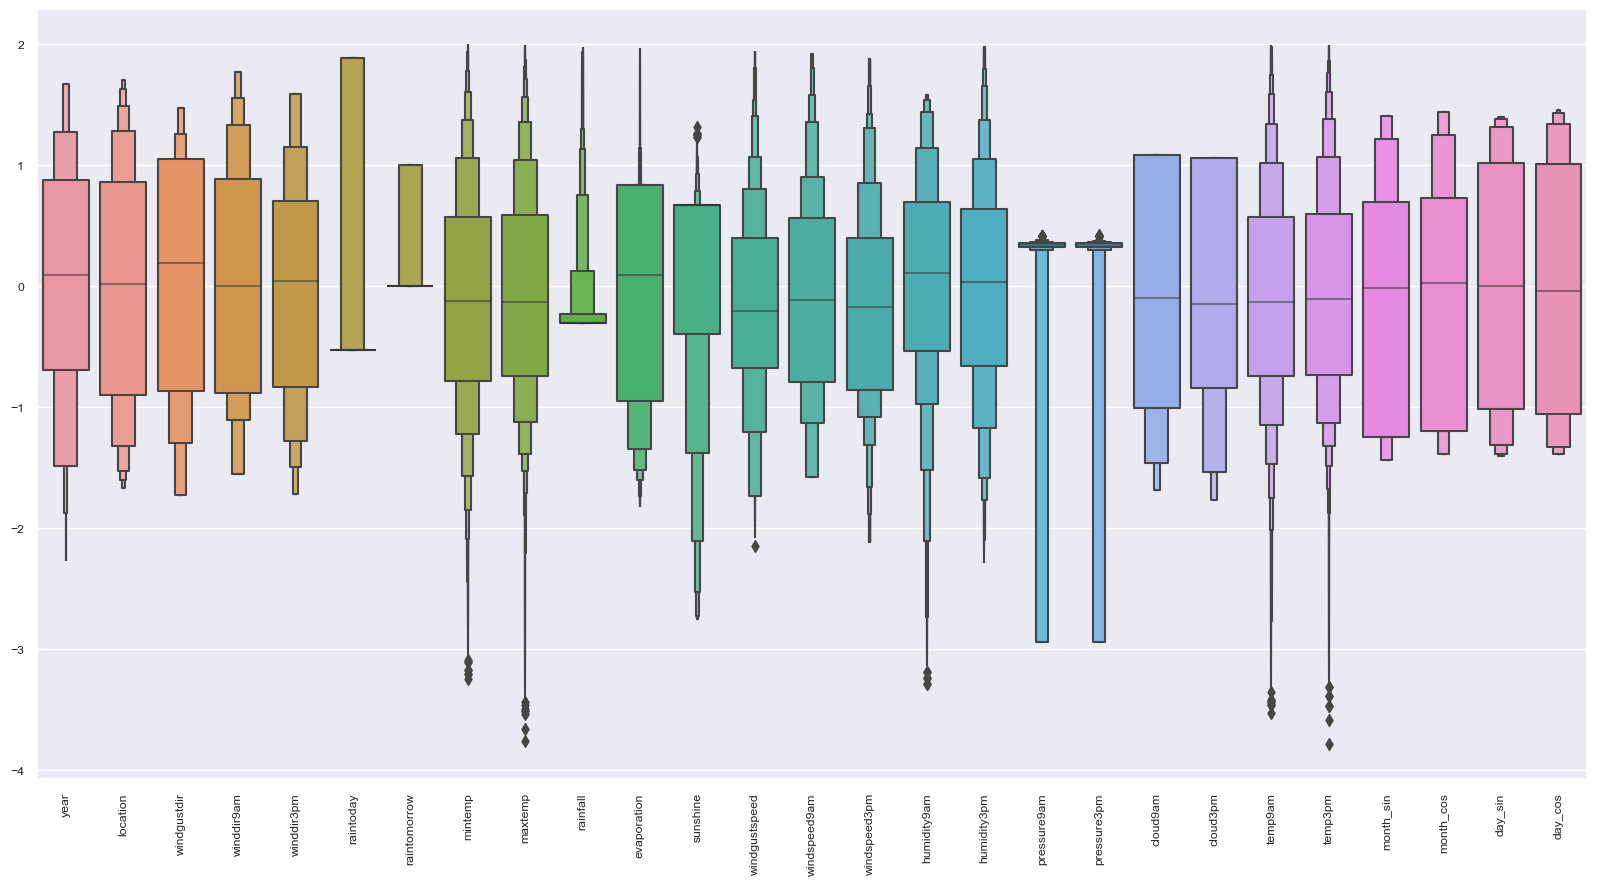

In [42]:
#detecting outliers
plt.figure(figsize=(20,10))
sns.boxenplot(data = scaled_df)
plt.xticks(rotation=90)
plt.show()

In [43]:
scaled_df = scaled_df[(scaled_df["mintemp"] > -2.3)]
scaled_df = scaled_df[(scaled_df["maxtemp"] > -2)]
scaled_df = scaled_df[(scaled_df["sunshine"]<1.2)]
scaled_df = scaled_df[(scaled_df["windgustspeed"]>-2)]
scaled_df = scaled_df[(scaled_df["humidity9am"]>-2)]
scaled_df = scaled_df[(scaled_df["humidity3pm"]>-1.5)]
#scaled_df = scaled_df[(scaled_df["temp9am"]>-2)]
#scaled_df = scaled_df[(scaled_df["temp3pm"]>-2)]

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\

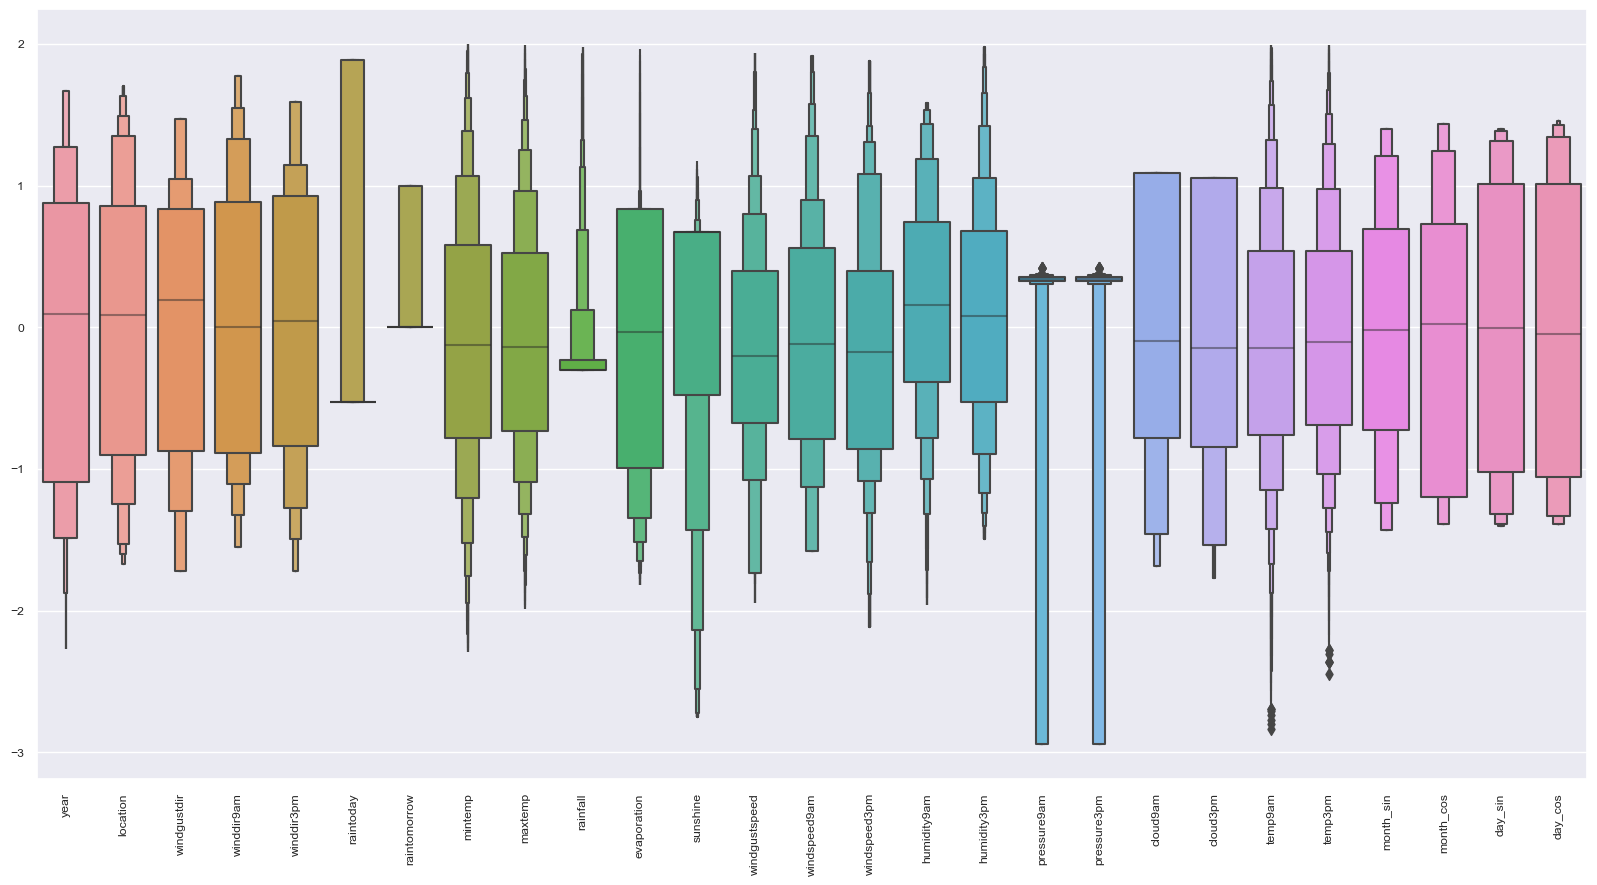

In [44]:
#detecting outliers
plt.figure(figsize=(20,10))
sns.boxenplot(data = scaled_df)
plt.xticks(rotation=90)
plt.show()

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\pc\AppData\Local\Programs\Python\Py

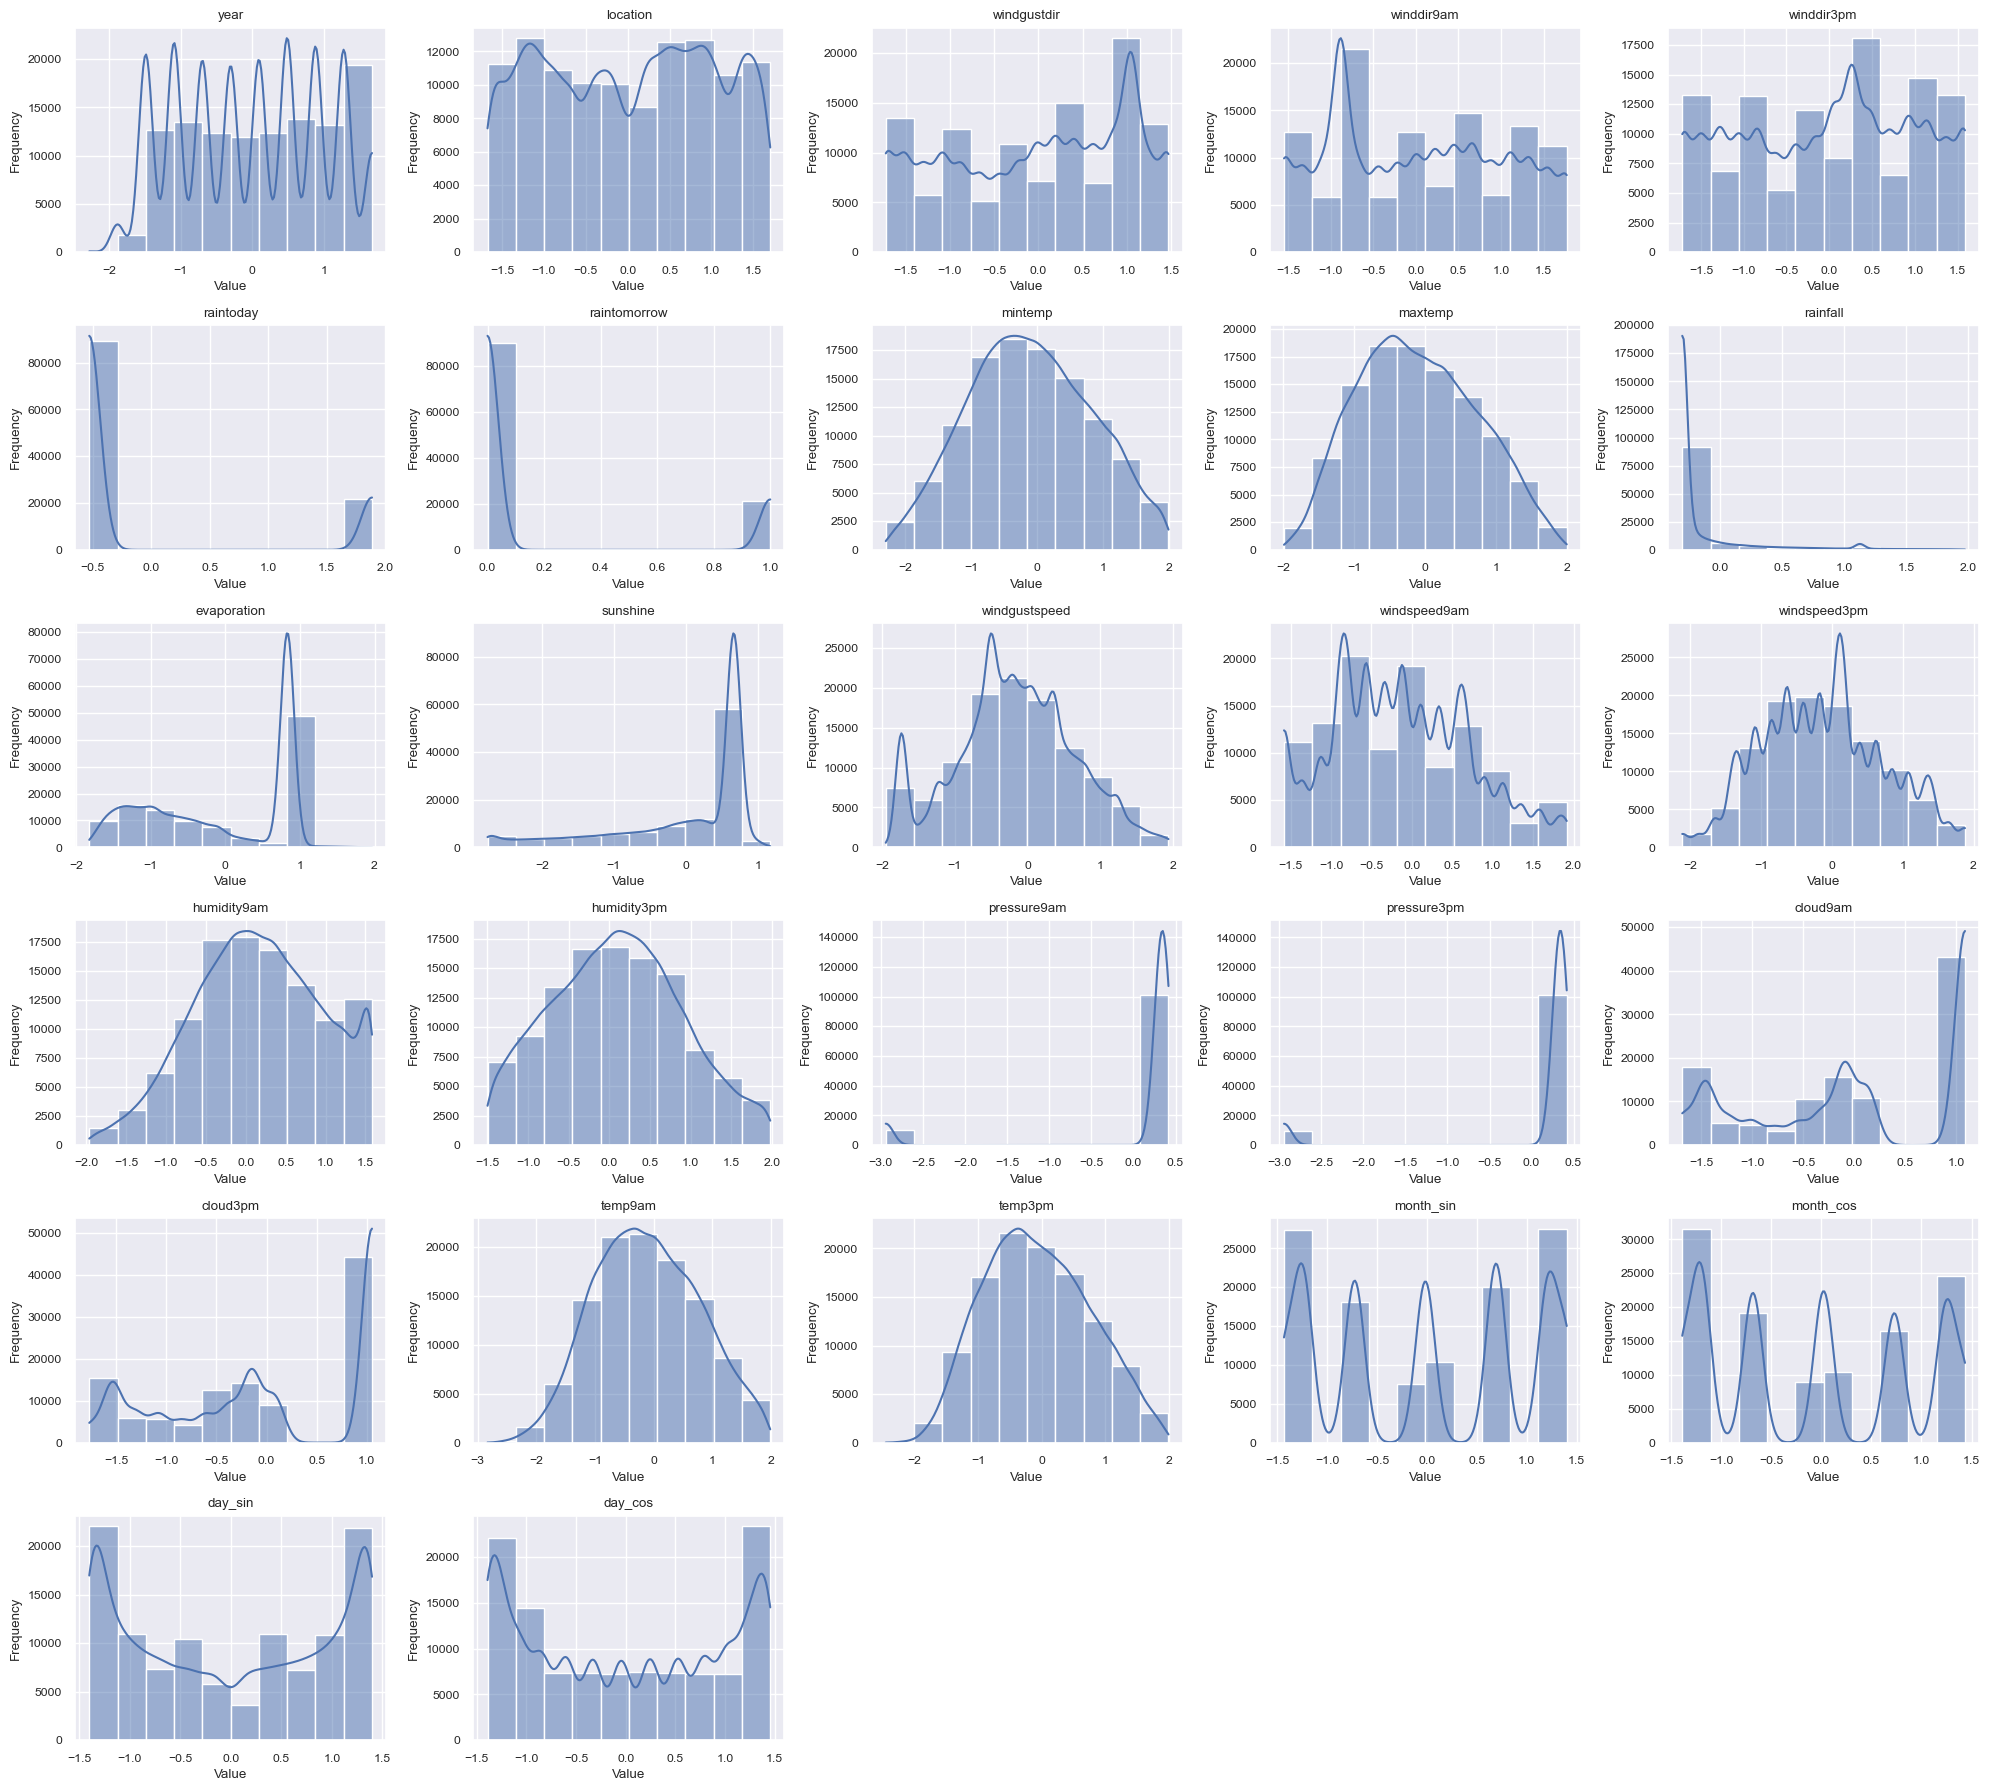

In [45]:
# Calculate the number of rows and columns for the subplots grid
num_columns = len(scaled_df.columns)
nrows = num_columns // 5 + (1 if num_columns % 5 != 0 else 0)
ncols = 5

# Create a figure with the calculated rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 3))

# Flatten the array of axes for easier indexing
axes = axes.flatten()

# Iterate over each column and plot a histogram using Seaborn
for i, col in enumerate(scaled_df.columns):
    sns.histplot(data=scaled_df, x=col, ax=axes[i], bins=10, kde=True)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Remove any unused axes (in case there are more subplots than columns)
for j in range(num_columns, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

### according to previous visualisations we get that our target variable is imbalanced so it leads to data leackage , we will handling this imbalancing using SMOTE sampling

In [46]:
from imblearn.over_sampling import SMOTE
# splitting data to train , test
x = scaled_df.drop(['raintomorrow'] , axis=1)
y = scaled_df['raintomorrow']
# Splitting data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.02, random_state=42)

# Apply SMOTE to training data 
smote = SMOTE(random_state=12)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

#x.shape , y.shape

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='raintomorrow', ylabel='Count'>

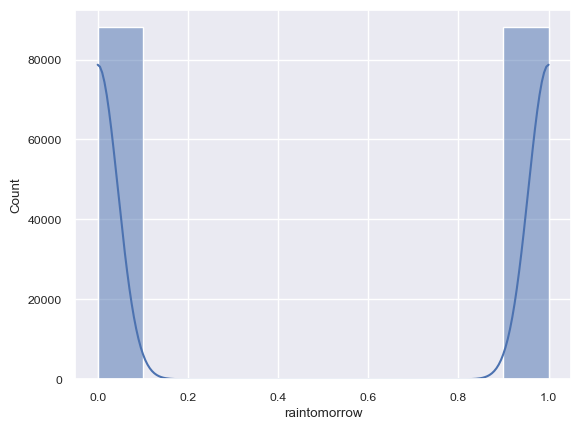

In [47]:
sns.histplot(data=y_train_resampled , bins=10 , kde=True)

# Modeling

In [48]:
# Initialize K-Fold with 5 splits
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
#Iterate over each fold
#for train_index, test_index in kf.split(x_train_resampled,y_train_resampled):
  #  x_train_fold, x_test_fold = x_train_resampled.iloc[train_index], x_train_resampled.iloc[test_index]
  # y_train_fold, y_test_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[test_index]


In [90]:
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train_resampled, y_train_resampled, batch_size = 32, epochs = 150, validation_split=0.2)


Epoch 1/150
4404/4404 [==============================] - 6s 1ms/step - loss: 0.5165 - accuracy: 0.7596 - val_loss: 0.6535 - val_accuracy: 0.6861
Epoch 2/150
4404/4404 [==============================] - 5s 1ms/step - loss: 0.4955 - accuracy: 0.7769 - val_loss: 0.6363 - val_accuracy: 0.6960
Epoch 3/150
4404/4404 [==============================] - 5s 1ms/step - loss: 0.4887 - accuracy: 0.7808 - val_loss: 0.6556 - val_accuracy: 0.6613
Epoch 4/150
4404/4404 [==============================] - 5s 1ms/step - loss: 0.4854 - accuracy: 0.7812 - val_loss: 0.6405 - val_accuracy: 0.6690
Epoch 5/150
4404/4404 [==============================] - 5s 1ms/step - loss: 0.4819 - accuracy: 0.7826 - val_loss: 0.6689 - val_accuracy: 0.6086
Epoch 6/150
4404/4404 [==============================] - 5s 1ms/step - loss: 0.4794 - accuracy: 0.7854 - val_loss: 0.6014 - val_accuracy: 0.6674
Epoch 7/150
4404/4404 [==============================] - 5s 1ms/step - loss: 0.4777 - accuracy: 0.7857 - val_loss: 0.5906 - val_a

In [115]:
model.save('australia_weather.keras')

In [116]:
model.save('australia_weather.h5')

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



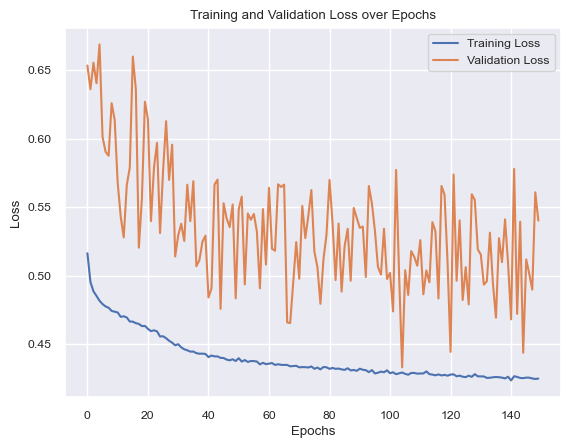

In [91]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a line plot
#plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

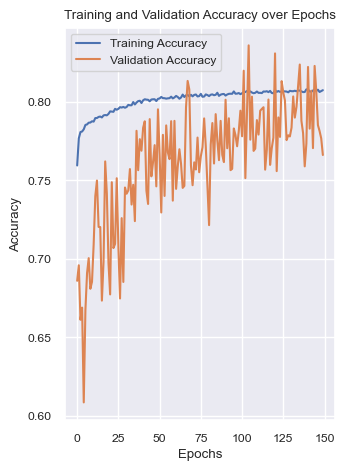

In [103]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
# Plot training and validation accuracy
plt.subplot(1, 2, 2)  # Subplot in a 1x2 grid, second plot
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

# Show the plots
plt.tight_layout()  

In [107]:
# Predicting the test set results
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)


70/70 [==============================] - 0s 695us/step


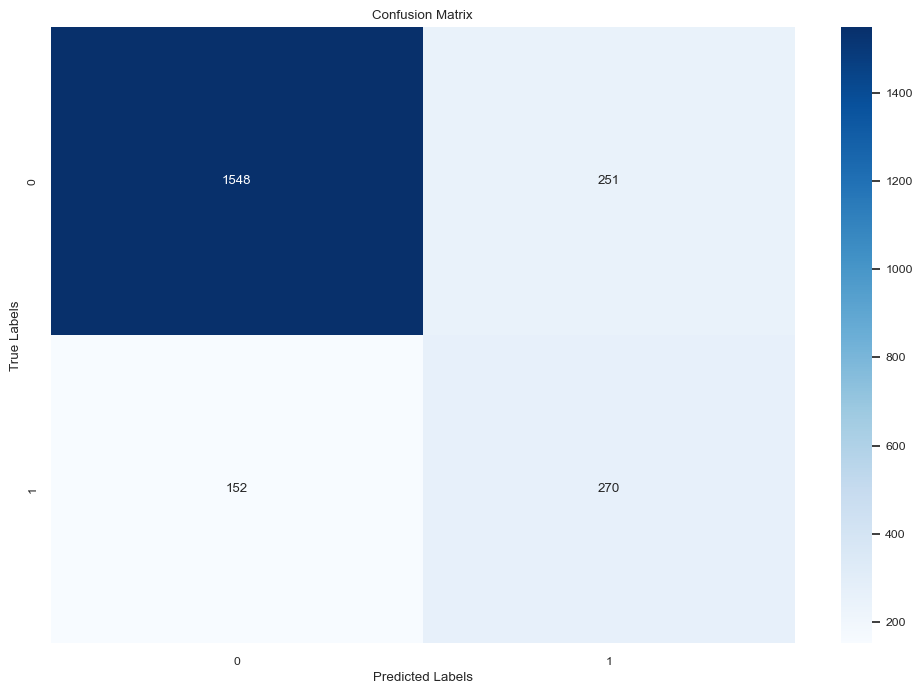

In [108]:
conf_matrix = confusion_matrix(y_test , y_pred)
plt.subplots(figsize=(12,8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<Axes: >

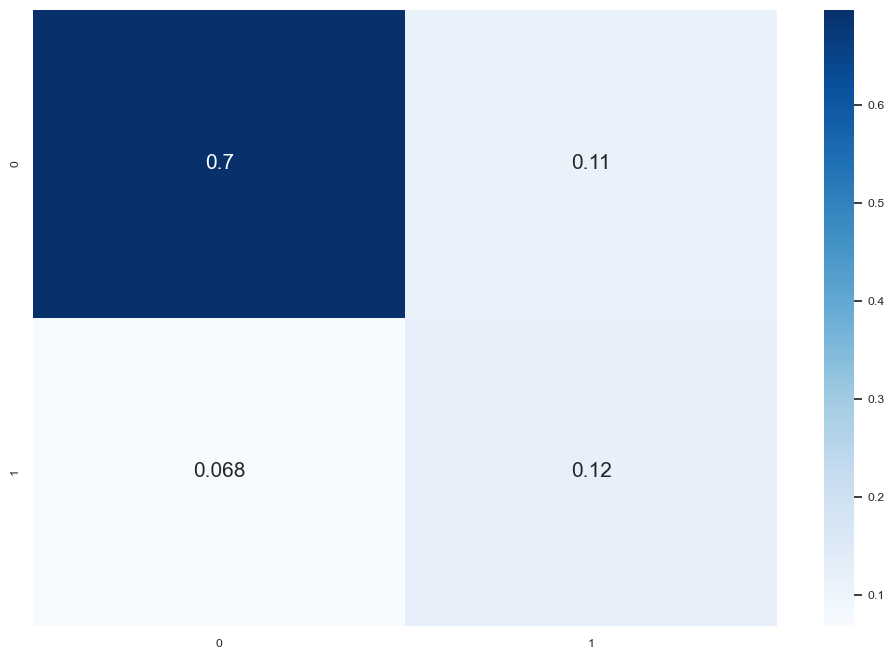

In [109]:
# confusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = 'Blues', annot = True, annot_kws = {'size':15})

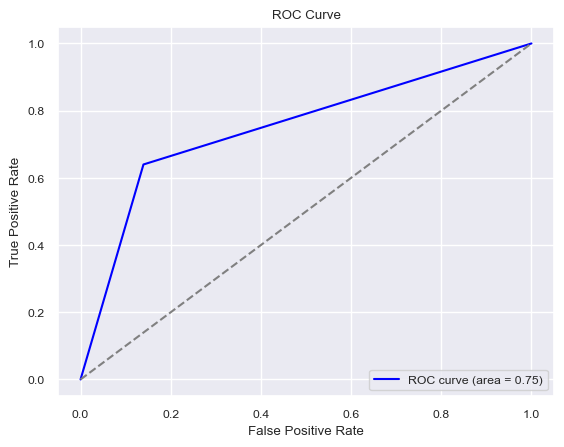

In [110]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [112]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1799
           1       0.52      0.64      0.57       422

    accuracy                           0.82      2221
   macro avg       0.71      0.75      0.73      2221
weighted avg       0.84      0.82      0.83      2221



In [113]:
#y_pred[551 : 561]  , y_train_resampled[551 : 561] 
y_pred[556] , y_train_resampled[556]

(array([ True]), 1)

In [ ]:
'''
import tkinter as tk
from tkinter import ttk
from keras.models import load_model

# Load your Keras model
model = load_model('rain_predection.h5')

# Create GUI
root = tk.Tk()
root.title("Rain Prediction")

# Labels
features_label = ttk.Label(root, text="Input Features")
features_label.grid(row=0, column=0, columnspan=2)

# Feature entries
# Example for Year
year_label = ttk.Label(root, text="Year:")
year_label.grid(row=8, column=0)
year_entry = ttk.Entry(root)
year_entry.grid(row=8, column=1)

# Example for Location
location_label = ttk.Label(root, text="Location:")
location_label.grid(row=9, column=0)
locations = ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
             'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
             'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
             'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
             'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
             'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
             'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
             'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
             'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
             'AliceSprings', 'Darwin', 'Katherine', 'Uluru']
location_combo = ttk.Combobox(root, values=locations)
location_combo.grid(row=9, column=1)

# Example for WindGustDir
wind_gust_dir_label = ttk.Label(root, text="Wind Gust Dir:")
wind_gust_dir_label.grid(row=10, column=0)
wind_gust_dir = ['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
                 'S', 'NW', 'SE', 'ESE', 'E', 'SSW']
wind_gust_dir_combo = ttk.Combobox(root, values=wind_gust_dir)
wind_gust_dir_combo.grid(row=10, column=1)

# Example for WindDir3pm
wind_dir_3pm_label = ttk.Label(root, text="Wind Dir 3pm:")
wind_dir_3pm_label.grid(row=11, column=0)
wind_dir_3pm = ['WNW', 'WSW', 'E', 'NW', 'W', 'SSE', 'ESE', 'ENE', 'NNW', 'SSW',
                'SW', 'SE', 'N', 'S', 'NNE', 'NE']
wind_dir_3pm_combo = ttk.Combobox(root, values=wind_dir_3pm)
wind_dir_3pm_combo.grid(row=11, column=1)

# Example for WindDir9am
wind_dir_9am_label = ttk.Label(root, text="Wind Dir 9am:")
wind_dir_9am_label.grid(row=12, column=0)
wind_dir_9am = ['W', 'NNW', 'SE', 'ENE', 'SW', 'SSE', 'S', 'NE', 'N', 'SSW', 'WSW',
                'ESE', 'E', 'NW', 'WNW', 'NNE']
wind_dir_9am_combo = ttk.Combobox(root, values=wind_dir_9am)
wind_dir_9am_combo.grid(row=12, column=1)

# Example for RainToday
rain_today_label = ttk.Label(root, text="Rain Today:")
rain_today_label.grid(row=13, column=0)
rain_today_combo = ttk.Combobox(root, values=['No', 'Yes'])
rain_today_combo.grid(row=13, column=1)

# Example for WindSpeed9am
wind_speed_9am_label = ttk.Label(root, text="Wind Speed 9am:")
wind_speed_9am_label.grid(row=14, column=0)
wind_speed_9am_entry = ttk.Entry(root)
wind_speed_9am_entry.grid(row=14, column=1)

# Example for WindSpeed3pm
wind_speed_3pm_label = ttk.Label(root, text="Wind Speed 3pm:")
wind_speed_3pm_label.grid(row=15, column=0)
wind_speed_3pm_entry = ttk.Entry(root)
wind_speed_3pm_entry.grid(row=15, column=1)

# Example for Humidity9am
humidity_9am_label = ttk.Label(root, text="Humidity 9am:")
humidity_9am_label.grid(row=16, column=0)
humidity_9am_entry = ttk.Entry(root)
humidity_9am_entry.grid(row=16, column=1)

# Example for Humidity3pm
humidity_3pm_label = ttk.Label(root, text="Humidity 3pm:")
humidity_3pm_label.grid(row=17, column=0)
humidity_3pm_entry = ttk.Entry(root)
humidity_3pm_entry.grid(row=17, column=1)

# Example for Pressure9am
pressure_9am_label = ttk.Label(root, text="Pressure 9am:")
pressure_9am_label.grid(row=18, column=0)
pressure_9am_entry = ttk.Entry(root)
pressure_9am_entry.grid(row=18, column=1)

# Example for Pressure3pm
pressure_3pm_label = ttk.Label(root, text="Pressure 3pm:")
pressure_3pm_label.grid(row=19, column=0)
pressure_3pm_entry = ttk.Entry(root)
pressure_3pm_entry.grid(row=19, column=1)

# Example for Cloud9am
cloud_9am_label = ttk.Label(root, text="Cloud 9am:")
cloud_9am_label.grid(row=20, column=0)
cloud_9am_entry = ttk.Entry(root)
cloud_9am_entry.grid(row=20, column=1)

# Example for Cloud3pm
cloud_3pm_label = ttk.Label(root, text="Cloud 3pm:")
cloud_3pm_label.grid(row=21, column=0)
cloud_3pm_entry = ttk.Entry(root)
cloud_3pm_entry.grid(row=21, column=1)

# Example for Temp9am
temp_9am_label = ttk.Label(root, text="Temp 9am:")
temp_9am_label.grid(row=22, column=0)
temp_9am_entry = ttk.Entry(root)
temp_9am_entry.grid(row=22, column=1)

# Example for Temp3pm
temp_3pm_label = ttk.Label(root, text="Temp 3pm:")
temp_3pm_label.grid(row=23, column=0)
temp_3pm_entry = ttk.Entry(root)
temp_3pm_entry.grid(row=23, column=1)

# Entry for Day
day_label = ttk.Label(root, text="Day (1-31):")
day_label.grid(row=4, column=0)
day_entry = ttk.Entry(root)
day_entry.grid(row=4, column=1)

# Example for Month
month_label = ttk.Label(root, text="Month:")
month_label.grid(row=5, column=0)
month_combo = ttk.Combobox(root, values=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
month_combo.grid(row=5, column=1)

# Button to predict
def predict():
    try:
        # Preprocess input
        input_features = [
            float(min_temp_entry.get()), float(max_temp_entry.get()), float(rainfall_entry.get()),
            float(evaporation_entry.get()), float(sunshine_entry.get()), float(wind_gust_speed_entry.get()),
            float(wind_speed_9am_entry.get()), float(wind_speed_3pm_entry.get()), float(humidity_9am_entry.get()),
            float(humidity_3pm_entry.get()), float(pressure_9am_entry.get()), float(pressure_3pm_entry.get()),
            float(cloud_9am_entry.get()), float(cloud_3pm_entry.get()), float(temp_9am_entry.get()),
            float(temp_3pm_entry.get())
        ]
        # Encode categorical features
        day_sin = np.sin(float(day_entry.get()) * (2 * np.pi / 31))
        day_cos = np.cos(float(day_entry.get()) * (2 * np.pi / 31))
        month_sin = np.sin(month_combo.current() * (2 * np.pi / 12))
        month_cos = np.cos(month_combo.current() * (2 * np.pi / 12))
        location_encoded = np.zeros(len(locations))
        location_encoded[location_combo.current()] = 1
        wind_gust_dir_encoded = np.zeros(len(wind_gust_dir))
        wind_gust_dir_encoded[wind_gust_dir.index(wind_gust_dir_combo.get())] = 1
        wind_dir_3pm_encoded = np.zeros(len(wind_dir_3pm))
        wind_dir_3pm_encoded[wind_dir_3pm.index(wind_dir_3pm_combo.get())] = 1
        wind_dir_9am_encoded = np.zeros(len(wind_dir_9am))
        wind_dir_9am_encoded[wind_dir_9am.index(wind_dir_9am_combo.get())] = 1
        rain_today_encoded = 1 if rain_today_combo.get() == 'Yes' else 0

        input_features.extend([day_sin, day_cos, month_sin, month_cos])
        input_features.extend(location_encoded)
        input_features.extend(wind_gust_dir_encoded)
        input_features.extend(wind_dir_3pm_encoded)
        input_features.extend(wind_dir_9am_encoded)
        input_features.append(rain_today_encoded)

        # Make prediction
        input_array = np.array([input_features])
        prediction = model.predict(input_array)

        # Display prediction
        if prediction[0][0] > 0.5:
            prediction_label.config(text="Prediction: Yes")
        else:
            prediction_label.config(text="Prediction: No")
    except ValueError:
        prediction_label.config(text="Invalid input. Please check your input values.")

predict_button = ttk.Button(root, text="Predict", command=predict)
predict_button.grid(row=24, column=0, columnspan=2, pady=10)

# Label for prediction output
prediction_label = ttk.Label(root, text="")
prediction_label.grid(row=25, column=0, columnspan=2)

root.mainloop()

'''




In [ ]:
'''
import tkinter as tk
from tkinter import ttk
# Load your trained model
dt =load_model('rain_predection.h5')

def on_select(event):
    print(f"Selected: {combo_box.get()}")

def predict():
    inputs = {
        "year": int(year_entry.get()),
        "day_sin": float(day_sin_entry.get()),
        "day_cos": float(day_cos_entry.get()),
        "month_sin": float(month_sin_entry.get()),
        "month_cos": float(month_cos_entry.get()),
        "location": location_combo.get(),
        "wind_gust_dir": wind_gust_dir_combo.get(),
        "wind_dir_3pm": wind_dir_3pm_combo.get(),
        "wind_dir_9am": wind_dir_9am_combo.get(),
        "rain_today": rain_today_combo.get(),
        "min_temp": float(min_temp_entry.get()),
        "max_temp": float(max_temp_entry.get()),
        "rainfall": float(rainfall_entry.get()),
        "evaporation": float(evaporation_entry.get()),
        "sunshine": float(sunshine_entry.get()),
        "wind_gust_speed": float(wind_gust_speed_entry.get()),
        "wind_speed_9am": float(wind_speed_9am_entry.get()),
        "wind_speed_3pm": float(wind_speed_3pm_entry.get()),
        "humidity_9am": float(humidity_9am_entry.get()),
        "humidity_3pm": float(humidity_3pm_entry.get()),
        "pressure_9am": float(pressure_9am_entry.get()),
        "pressure_3pm": float(pressure_3pm_entry.get()),
        "cloud_9am": float(cloud_9am_entry.get()),
        "cloud_3pm": float(cloud_3pm_entry.get()),
        "temp_9am": float(temp_9am_entry.get()),
        "temp_3pm": float(temp_3pm_entry.get())
    }
    
    # Prepare input data for prediction with feature names
    feature_names = [
        "year", "day_sin", "day_cos", "month_sin", "month_cos", "location", "wind_gust_dir",
        "wind_dir_3pm", "wind_dir_9am", "rain_today", "min_temp", "max_temp", "rainfall",
        "evaporation", "sunshine", "wind_gust_speed", "wind_speed_9am", "wind_speed_3pm",
        "humidity_9am", "humidity_3pm", "pressure_9am", "pressure_3pm", "cloud_9am", "cloud_3pm",
        "temp_9am", "temp_3pm"
    ]
    input_data = np.array([inputs[feature] for feature in feature_names]).reshape(1, -1)
    input_df = pd.DataFrame(input_data, columns=feature_names)
    
    # Make prediction using the trained classifier
    prediction = dt.predict(input_df)
    
    # Display prediction result
    result_label.config(text=f"Predicted Stroke Tomorrow: {prediction[0]}")

root = tk.Tk()
root.title("Stroke Prediction")
root.geometry("1080x720")

title_font = ("Arial", 12, "bold")
num_label_font = ("Arial", 14, "bold")

options = ["True", "False"]
day_options = list(range(1, 32))
month_options = list(range(1, 13))

titles = ["year", "day_sin", "day_cos", "month_sin", "month_cos", "location", "wind_gust_dir",
        "wind_dir_3pm", "wind_dir_9am", "rain_today"]

combo_boxes = {}

for title in titles:
    frame = tk.Frame(root)
    frame.pack(padx=20, pady=10)
    
    label = tk.Label(frame, text=title.replace("_", " ").title(), font=title_font)
    label.pack(padx=10, pady=(0, 5))
    
    if title == "location":
        combo_box = ttk.Combobox(frame, values=['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
                                                'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
                                                'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
                                                'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
                                                'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
                                                'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
                                                'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
                                                'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
                                                'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
                                                'AliceSprings', 'Darwin', 'Katherine', 'Uluru'])
    elif title in ["day_sin", "day_cos"]:
        combo_box = ttk.Combobox(frame, values=day_options)
    elif title in ["month_sin", "month_cos"]:
        combo_box = ttk.Combobox(frame, values=month_options)
    else:
        combo_box = ttk.Combobox(frame, values=options)
        
    combo_box.set(options[0])
    combo_box.pack(padx=10, pady=(5, 10))
    combo_boxes[title] = combo_box

entry_titles = ["min_temp", "max_temp", "rainfall", "evaporation", "sunshine", "wind_gust_speed",
                "wind_speed_9am", "wind_speed_3pm", "humidity_9am", "humidity_3pm", "pressure_9am",
                "pressure_3pm", "cloud_9am", "cloud_3pm", "temp_9am", "temp_3pm"]

entry_widgets = {}
for title in entry_titles:
    frame = tk.Frame(root)
    frame.pack(padx=20, pady=10)

    label = tk.Label(frame, text=title.replace("_", " ").title(), font=num_label_font)
    label.pack(padx=10, pady=(0, 5))

    entry = tk.Entry(frame)
    entry.pack(padx=10, pady=(5, 10))
    entry_widgets[title] = entry

button = tk.Button(root, text="Predict", command=predict)
button.place(relx=0.5, rely=0.82, anchor=tk.CENTER)

result_label = tk.Label(root, text="", font=num_label_font)
result_label.pack(pady=20)

root.mainloop()
'''